In [1]:
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
import spacy
import gensim
from gensim import corpora
from gensim.models import TfidfModel, CoherenceModel
import pyLDAvis.gensim
from wordcloud import WordCloud

# Suppress future warning messages from sklearn.manifold._mds, when visualizing pyLDAvis
# Suppress package deprecation warnings for functions that I'm not using
warnings.filterwarnings("ignore", category = FutureWarning, module = "sklearn.manifold._mds")
warnings.filterwarnings("ignore", category = DeprecationWarning)

# import random

## 1. Clean the abstract

#### Access the scraped data from the NYT & Fox news


In [2]:
def load_data(file_name):
    
    # Construct filepath
    file_path = f"./1_Data/{file_name}.csv"
    
    # Read in the csv file
    data = pd.read_csv(file_path) 

    # Convert the 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

NYT = load_data("NYT")
foxnews = load_data("foxnews")

#### Construct custom stopwords

In [3]:
### Add & remove stopwords

nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])

add_to_stopwords = {"climate", "change", "global", "warming", "warm", "environment", "environmental", "planet", "earth",
                    "study", "studies", "research", "report", "reporter", "analysis", "data", "datum", "according",
                    "work", "project", "plan", "program", "researcher", "expert", "scientist", "record", "source",
                    "people", "public", "thing", "community", "group", "region", "role", "method", "way", "road", "path",
                    "says", "said", "announce", "suggest", "suggests", "show", "shows", "explain", "explains", "explained", "release", "reveal", "find", "finds",
                    "know", "question", "answer", "think", "include", "mean", "means",
                    "propose", "expect", "reach", "come", "bring", "start", "create", "run",
                    "help", "continue", "want", "need", "require",
                    "like", "likely", "look", "looks", "nearly", "near", "away",
                    "fight", "combat", "address", "face", "action", "effort", "try", "challenge",
                    "impact", "effect", "affect", "meet", "reach", "goal", "aim", "objective",
                    "year", "month", "month", "week", "weeks", "days", "decade", "century", "ago", "time", "late", "early", "future", "past", "yesterday", "today", "tomorrow", "recent",
                    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "hundred", "thousand", "million", "billion", "percent", "half", "quarter", "number",
                    "average", "common"}

custom_stopwords = nlp.Defaults.stop_words | add_to_stopwords


### Verify that the stopwords have been added correctly
print(f"Number of stopwords in the original list: {len(nlp.Defaults.stop_words)}")
print(f"Number of stopwords in the custom list: {len(custom_stopwords)}")

Number of stopwords in the original list: 326
Number of stopwords in the custom list: 452


#### Remove stopwords and perform lemmatization

In [4]:
### Define a function that cleans the abstract

def preprocess_text(abstract):
    
    # Convert the abstract to lowercase
    lowercase_abstract = abstract.lower()
    
    # Define strings that I want to remove - punctuations and digits
    # This is to keep and to clean words such as 'COP26', 'COP28' -> 'COP' / 'E.P.A' -> 'EPA'
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    
    # Apply the translation table to clean the abstract
    no_digits_punctuations = lowercase_abstract.translate(translation_table)


    # If a given word is not a stopword, perform tokenization
    tokenized_non_stopwords = [word for word in word_tokenize(no_digits_punctuations)
                               if word not in custom_stopwords]
        
    # Work with only non-stopwords (i.e. Remove stopwords):
    # If a given word consists of at least 2 characters in length, perform parts-of-speech tagging and then lemmatization
    lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(tokenized_non_stopwords)) # Join the list of tokenized words into a single string. Add a whitespace in between each word
                         if len(token.text) > 2]
    
    # The 'lemmatized' output may contain some stopwords. Perform additional round of cleaning by removing such stopwords
    stopwords_removed = [token for token in lemmatized_tokens if token not in custom_stopwords]
    
    return stopwords_removed

In [5]:
### Store the preprocessed abstract (i.e. Converted to lowercase, tokenized, with punctuations removed, and lemmatized)

def return_cleaned_abstract(data):
    return [preprocess_text(abstract) for abstract in data["abstract"]]

#### Construct ngrams (up to trigrams)

In [6]:
### Create bigram & trigram phrases from tokenized text

def create_ngrams(cleaned_abstract):
    
    # Identify commonly occurring bigrams in a corpus

    bigram_phrases = gensim.models.Phrases(
        cleaned_abstract, # tokenized text
        min_count = 5, # minimum frequency of a 'pair of tokens', for it to be considered a bigram
        # would have to fiddle around with the 'threshold' argument;
        # threshold = measures how often the bigram must occur (compared to individual words)
        # for it to be considered a valid phrase
        # determines the number of phrases that are found
        # *higher* threshold = *fewer* number of phrases
        # -> because only trigrams with a score > 15 are considered meaningful, instead of the default = 10
        threshold = 15)

    # Identify commonly occurring trigrams, by building on the bigrams obtained earlier
    # Identifies sequences of 3 words that occur together more often than expected by chance,
    # given the occurences of their constituent bigrams & individual words
    trigram_phrases = gensim.models.Phrases(
        # Grab the bigrams, index 
        # Look at overlaps between bigrams & other words in the corpus
        # -> uses a threshold to determine which trigrams are considered important
        bigram_phrases[cleaned_abstract],
        threshold = 15)

    # Create a 'phraser' object from the bigrams and trigrams, respectively
    # To apply the learned phrase models to new documents
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)


    # Get a list of unigrams, bigrams, trigrams
    return [trigram[bigram[preprocessed_tokens]] for preprocessed_tokens in cleaned_abstract]

In [7]:
### Examine bigrams and trigrams

def print_unique_ngrams(source, ngrams_list):
    
    # Extract unique trigrams (tokens containing two underscores)
    unique_trigrams = set(token for ngram_tokens in ngrams_list
                          for token in ngram_tokens
                          if token.count('_') == 2)

    # Extract unique bigrams (tokens containing only one underscore)
    unique_bigrams = set(token for ngram_tokens in ngrams_list
                         for token in ngram_tokens
                         if token.count('_') == 1)

    print(f"[{source}] -------------------------------\n")
    print(f"Trigrams: \n{unique_trigrams}\n")
    print(f"Bigrams: \n{unique_bigrams}\n\n")

##### Run all the custom functions:

In [8]:
# Iterate over the dataset names:
dataset_names = ['NYT', 'Foxnews']

# Dictionary to store datasets and their cleaned abstracts
datasets = {}


for dataset_name in dataset_names:
    # Load the data
    data = load_data(dataset_name)

    ### Get the cleaned abstract - converted to lowercase, stopwords/numbers/punctuations removed and lemmatized,
    cleaned_abstract = return_cleaned_abstract(data)

    ### Add a separate column for the lemmatized and preprocessed abstract
    data['cleaned_abstract'] = cleaned_abstract

    ### Store as csv -> for emotion analysis
    data.to_csv(f"./1_Data/{dataset_name}_cleaned_abstract.csv", index=False)

    ### Create bigram & trigram phrases from tokenized text
    ngrams = create_ngrams(cleaned_abstract)

    ### Store data, cleaned abstract, and ngrams in the datasets dictionary
    datasets[dataset_name] = {'data': data, 'cleaned_abstract': cleaned_abstract, 'ngrams': ngrams}

### Print unique ngrams for each dataset
for dataset_name, content in datasets.items():
    print_unique_ngrams(dataset_name, content['ngrams'])

### Access the cleaned abstracts & unigrams/bigrams/trigrams list, for later:
# NYT
NYT_cleaned_abstract = datasets['NYT']['cleaned_abstract']
NYT_ngrams = datasets['NYT']['ngrams']

# Fox News
foxnews_cleaned_abstract = datasets['Foxnews']['cleaned_abstract']
foxnews_ngrams = datasets['Foxnews']['ngrams']

[NYT] -------------------------------

Trigrams: 
{'fossil_fuel_industry', 'reduce_greenhouse_gas', 'greenhouse_gas_emission', 'oil_gas_drilling', 'fuel_economy_standard'}

Bigrams: 
{'fuel_economy', 'federal_judge', 'paris_agreement', 'united_states', 'epa_chief', 'scott_pruitt', 'hurricane_season', 'protection_agency', 'cut_greenhouse', 'national_park', 'president_trump', 'power_plant', 'sea_level', 'planetwarme_gas', 'fossil_fuel', 'polar_bear', 'greenhouse_gas', 'extreme_weather', 'regulatory_rollback', 'cut_emission', 'wind_solar', 'joe_manchin', 'sea_ice', 'world_leader', 'joe_biden', 'develop_country', 'san_francisco', 'deb_haaland', 'coal_plant', 'natural_gas', 'president_biden', 'marine_life', 'federal_government', 'flood_zone', 'white_house', 'national_wildlife', 'joseph_biden', 'united_nations', 'heat_wave', 'clean_energy', 'west_virginia', 'extreme_heat', 'andrew_wheeler', 'carbon_dioxide', 'oil_gas', 'gas_emission', 'inspector_general', 'air_pollution', 'biden_administrati

## 2. Reduce the size of the dictionary
#### Determine the optimal level of minimum frequency

In [9]:
### Plot minimum frequency vs dictionary size

def examine_vocab_size_by_min_freq(data, ngrams):
    
    # Different min_frequency values to try
    min_frequency_values = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045]
    
    # Dictionary to store the sizes of the dictionary at different min_frequency values
    dictionary_sizes = {}

    # Create a dictionary (retrieve unique tokens across documents)
    dictionary = corpora.Dictionary(ngrams)

    for min_frequency in min_frequency_values:
        
        ## Remove extremely rare words
        
        # Specify a minimum frequency and maximum frequency of 80% 
        lower_bound = round(data.shape[0] * min_frequency) # Round to the nearest integer; Has to be an *ABSOLUTE* number

        # Apply the minimum and maximum frequency thresholds
        dictionary.filter_extremes(no_below = lower_bound, no_above = 0.8)

        # Store the size of the dictionary given the min_frequency value
        dictionary_sizes[min_frequency] = len(dictionary)

        # Reset the dictionary to its original state for the next iteration
        dictionary = corpora.Dictionary(ngrams)

    # Convert the results to a dataFrame, so that we can plot dictionary size at various min_frequency_values
    df = pd.DataFrame(list(dictionary_sizes.items()),
                      columns = ['min_frequency_values', 'dictionary_size'])
    
    # Plot a line graph
    plt.figure(figsize = (7, 3))
    plt.plot(df['min_frequency_values'], df['dictionary_size'], marker = 'o')
    plt.title('Selecting the optimal threshold for minimum frequency')
    plt.xlabel('Minimum Frequency')
    plt.ylabel('Dictionary Size')
    # Add dashed line at the optimal threshold
    plt.axvline(x = 0.002, ls = ':', color = 'navy', lw = 1.8)
    plt.grid(True)
    plt.show()

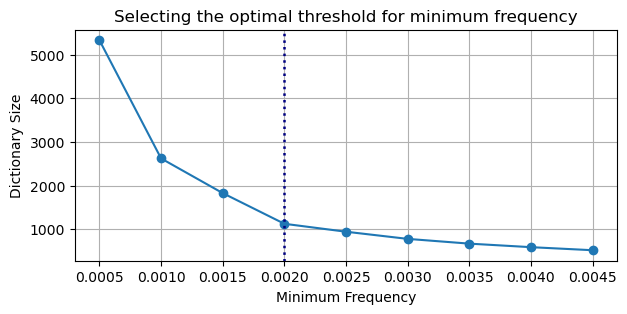

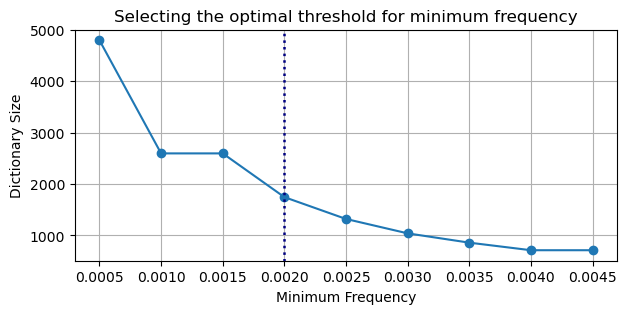

In [10]:
### For both datasets, apply minimum frequency of 0.002

examine_vocab_size_by_min_freq(NYT, NYT_ngrams)
examine_vocab_size_by_min_freq(foxnews, foxnews_ngrams)

#### Apply the optimal min_frequency selected above.

In [11]:
def reduce_dictionary(data, ngrams, min_frequency):
    
    #### 1) Create a dictionary (retrieve unique tokens across documents)
    dictionary = corpora.Dictionary(ngrams)

    #### 2) Remove extremely rare common words
    lower_bound = round(data.shape[0]*min_frequency) # Round to the nearest integer; Has to be an *ABSOLUTE* number
    dictionary.filter_extremes(no_below = lower_bound, no_above = 0.8)
    
    return dictionary

In [12]:
NYT_dictionary = reduce_dictionary(NYT, NYT_ngrams, 0.002)
foxnews_dictionary = reduce_dictionary(foxnews, foxnews_ngrams, 0.002)

## 3. Apply tf-idf weighting
#### Convert the abstract into bag-of-words

In [13]:
### For tokens that remain in the filtered dictionary,
# convert the document (abstract) into bag-of-words format (MUST APPLY THE DICTIONARY TO *TOKENIZED AND PREPROCESSED* WORDS)
# Count the number of occurrences of a given token, in that *particular document* (NOT THE ENTIRE CORPUS!)
# Output is a tuple: (token_ID, frequency_of_the_token)

NYT_bag_of_words_corpus = [NYT_dictionary.doc2bow(abstract, allow_update = True) for abstract in NYT_ngrams]
foxnews_bag_of_words_corpus = [foxnews_dictionary.doc2bow(abstract, allow_update = True) for abstract in foxnews_ngrams]

# To convert the results to human-readable format:
# token_frequency_within_each_doc = [[(NYT_dictionary[token_ID], frequency) for token_ID, frequency in abstract] for abstract in bag_of_words_corpus]
# random.sample(token_frequency_within_each_doc, 5)

#### Fit the tf-idf model

In [14]:
# Don't apply any variants to tf-idf
NYT_tfidf_model = gensim.models.TfidfModel(NYT_bag_of_words_corpus, normalize = False)
foxnews_tfidf_model = gensim.models.TfidfModel(foxnews_bag_of_words_corpus, normalize = False)

# Apply tf-idf to the entire corpus
# Transform the bag-of-words representation (integer counts) into tf-idf representation (real number, weights)
NYT_tfidf_corpus = NYT_tfidf_model[NYT_bag_of_words_corpus]
foxnews_tfidf_corpus = foxnews_tfidf_model[foxnews_bag_of_words_corpus]

# Print the Tfidf representation for each document
# The weight of each word is inversely proportional to the frequency of the word in that document.
# Higher tf-idf scores = higher importance of the word within the document

# for i, abstract in enumerate(NYT_tfidf_corpus[:2]):
#    print(f"Document {i + 1}: {abstract}")

## 4. Define the optimal number of topics
#### Calculate the perplexity and coherence scores

In [15]:
### Save the scores as a dataframe

def compute_coherence_perplexity_scores(tfidf_corpus, dictionary, ngrams):
    
    model_evaluation = {
        'n_topics': [],
        'perplexity_scores': [],
        'coherence_scores_cv': []}
    
    for n_topic in range(2, 31):
        
        ### I. Instantiate the LDA topic model (= train the LDA model on the corpus)
        # With this LDA model, we can:
        # 1) explore the topics that were discovered,
        # 2) examine the most representative words for each topic,
        # 3) analyze the distribution of topics across documents
        lda_model = gensim.models.ldamodel.LdaModel(
            # The corpus that we created from the dictionary
            corpus = tfidf_corpus,
            # The dictionary to use
            id2word = dictionary,
            # Number of topics for the LDA model to discover
            num_topics = n_topic, 
            # For replicability
            random_state = 406,
            # Update the model parameters at every iteration (iterative learning)
            update_every = 1,
            # Number of documents to be used in each training.
            # -> impacts memory usage and training speed.
            chunksize = 400,
            # Number of times the entire corpus is iterated over during training.
            # Each pass involves processing the entire corpus once.
            # Using a higher number will lead to a longer training time, but sometimes higher-quality topics.
            passes = 20,
            # Allows for an extraction of the most likely topics given a word.
            # Every word will be assigned to a topic. Otherwise, words that are not indicative are going to be omitted.
            per_word_topics = True,
            # Control the sparsity of the document-topic distribution (hyperparameter)
            # = https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
            # "auto": Gensim will learn an asymmetric prior from the data. Alpha parameter will be tuned automatically.
            alpha = "auto",
            # beta (hyperparameter)
            eta = "auto")


        ### II. Calculate topic coherence
        coherence_model_cv = CoherenceModel(model = lda_model,
                                            texts = ngrams,
                                            dictionary = dictionary,
                                            coherence = 'c_v')
        coherence_score_cv = round(coherence_model_cv.get_coherence(), 3)

        
        
        ### III. Calculate perplexity scores
        perplexity_score = round(lda_model.log_perplexity(tfidf_corpus), 3)
         
        # IV. Store the LDA tf-idf model, number of topics, perplexity scores, and coherence scores
        model_evaluation['n_topics'].append(n_topic)
        model_evaluation['perplexity_scores'].append(perplexity_score)
        model_evaluation['coherence_scores_cv'].append(coherence_score_cv)
        
    results = pd.DataFrame(model_evaluation)
    return results

In [16]:
NYT_evaluation_metrics = compute_coherence_perplexity_scores(NYT_tfidf_corpus, NYT_dictionary, NYT_ngrams)

In [17]:
foxnews_evaluation_metrics = compute_coherence_perplexity_scores(foxnews_tfidf_corpus, foxnews_dictionary, foxnews_ngrams)

#### Plot the perplexity and coherence scores against the number of topics

In [18]:
### Create a line graph

def plot_evaluation_metrics(data, filename):
    
    plt.figure(figsize = (6, 4))

    ### 1) Plot the coherence scores
    plt.subplot(2, 1, 1)  # Plot 2 line graphs on 2 rows, 1 column. Plot the first subplot

    plt.title(f"Selecting the optimal number of topics for: {filename}", fontsize = 13, fontweight = "bold")
    plt.plot(data['n_topics'], data['coherence_scores_cv'], marker = 'o', markersize = 4)
    plt.ylabel("Coherence score", fontweight = "bold")

    # Set x-axis ticks at increments of 2
    plt.xticks(range(min(data['n_topics']), max(data['n_topics']) + 1, 2))

    # Add gridlines
    plt.grid(True, linestyle = "dashed")
    plt.minorticks_on()



    ### 2) Plot the perplexity scores
    plt.subplot(2, 1, 2)  # Plot 2 line graphs on 2 rows, 1 column. Plot the second subplot
    plt.plot(data['n_topics'], data['perplexity_scores'], marker = 'o', markersize = 4, color = 'green')

    plt.ylabel("Perplexity score", fontweight = "bold")
    plt.xlabel("Number of Topics", fontweight = "bold")

    # Set x-axis ticks at increments of 2
    plt.xticks(range(min(data['n_topics']), max(data['n_topics']) + 1, 2))

    # Add gridlines
    plt.grid(True, linestyle = "dashed")
    plt.minorticks_on()

    plt.tight_layout()
    plt.savefig(f"./2_Figures/{filename}_evaluation_metrics.png")
    plt.show()


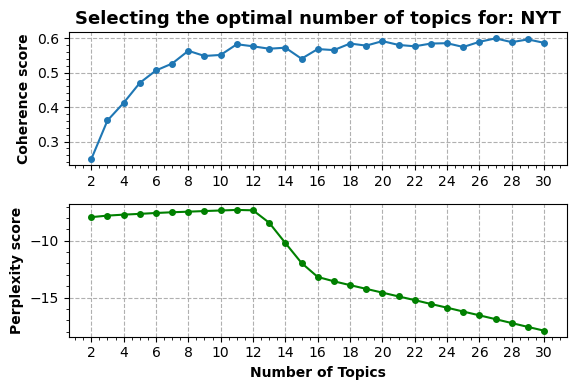

In [19]:
plot_evaluation_metrics(NYT_evaluation_metrics, "NYT")

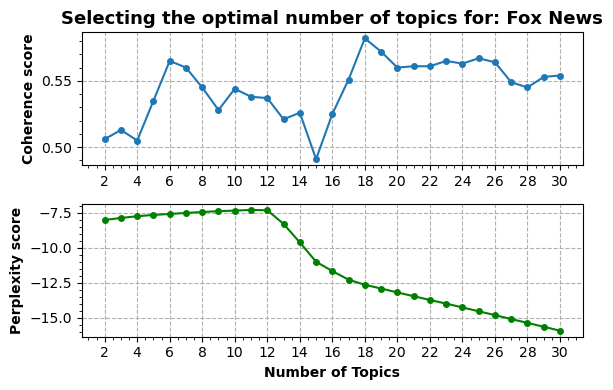

In [20]:
plot_evaluation_metrics(foxnews_evaluation_metrics, "Fox News")

## 5. Construct an LDA model based on the optimal number of topics

In [21]:
def create_lda_tfidf_model(optimal_n_topic, tfidf_corpus, dictionary):
    
    # Instantiate the LDA topic model (= train the LDA model on the corpus)
    model = gensim.models.ldamodel.LdaModel(
        corpus = tfidf_corpus,
        id2word = dictionary,
        num_topics = optimal_n_topic, 
        random_state = 406,
        update_every = 1,
        chunksize = 400,
        passes = 20,
        per_word_topics = True,
        alpha = "auto",
        eta = "auto")

    return model

In [22]:
NYT_lda_tfidf = create_lda_tfidf_model(12, NYT_tfidf_corpus, NYT_dictionary)
foxnews_lda_tfidf = create_lda_tfidf_model(6, foxnews_tfidf_corpus, foxnews_dictionary)

## 6. Visualize top words for each topic

#### For interactivity:

In [23]:
### Display the visualization in Jupyter Notebook environment
pyLDAvis.enable_notebook()

# Transform & prepare the model for visualization 
NYT_visualization  = pyLDAvis.gensim.prepare(
    NYT_lda_tfidf,
    NYT_tfidf_corpus,
    NYT_dictionary,
    mds = "mmds",
    # The number of terms to display in the barchart (Default = 30)
    # Recommended range of R: 10 ~ 50
    R = 30)

NYT_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.398190  0.152587       1        1  10.067668
8     -0.241773  0.370569       2        1   9.300384
2      0.307797 -0.240942       3        1   9.133393
1      0.014726  0.403121       4        1   8.954887
3     -0.072396  0.058463       5        1   8.536049
10    -0.416562 -0.117695       6        1   8.419586
4      0.264405  0.109600       7        1   8.019800
11     0.460560 -0.016013       8        1   7.932020
0     -0.088628 -0.241844       9        1   7.652704
7      0.136516 -0.426958      10        1   7.597903
5      0.279551  0.356122      11        1   7.343928
9     -0.246006 -0.407010      12        1   7.041677, topic_info=            Term        Freq       Total Category  logprob  loglift
200  fossil_fuel  348.000000  348.000000  Default  30.0000  30.0000
70        nation  344.000000  344.000000  Default  29.0000  29.0000
428         talk  313.000000  313.000000  Default  28.0000  28.0000
243        storm  496.000000  496.000000  Default  27.0000  27.0000
26     hurricane  303.000000  303.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
54         leave  117.419406  176.003347  Topic12  -4.6584   2.2486
214          ice  120.594345  187.944597  Topic12  -4.6317   2.2096
88        animal  115.203604  226.783733  Topic12  -4.6774   1.9760
72         raise   85.520660  128.777502  Topic12  -4.9754   2.2440
189        large   89.206815  259.207005  Topic12  -4.9332   1.5867

[521 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
170       3  0.994974           act
343       4  0.852506      activist
343       9  0.143737      activist
275      12  0.987925       adviser
268       2  0.089431        agency
...     ...       ...           ...
312      12  0.041635         world
807       9  0.986845  world_leader
576       9  0.992457     worldwide
1035      5  0.987046        worsen
497       8  0.987496         young

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 3, 2, 4, 11, 5, 12, 1, 8, 6, 10])

In [24]:
foxnews_visualization  = pyLDAvis.gensim.prepare(
    foxnews_lda_tfidf,
    foxnews_tfidf_corpus,
    foxnews_dictionary,
    mds = "mmds",
    R = 20)

foxnews_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.170352 -0.270043       1        1  18.177971
4     -0.180280  0.292602       2        1  17.982226
3      0.187637 -0.320864       3        1  16.918054
0      0.176114  0.313375       4        1  16.451807
1      0.360592 -0.010906       5        1  16.343268
5     -0.373711 -0.004164       6        1  14.126674, topic_info=              Term        Freq       Total Category  logprob  loglift
792     antarctica  468.000000  468.000000  Default  20.0000  20.0000
1546           ice  404.000000  404.000000  Default  19.0000  19.0000
1554  thunderstorm  282.000000  282.000000  Default  18.0000  18.0000
800           fast  249.000000  249.000000  Default  17.0000  17.0000
1545     greenland  241.000000  241.000000  Default  16.0000  16.0000
...            ...         ...         ...      ...      ...      ...
4752     geneedite  159.740934  219.630914   Topic6  -4.8631   1.6387
799           fall  128.215611  147.878838   Topic6  -5.0829   1.8144
666            hot  132.980021  166.504521   Topic6  -5.0464   1.7323
355    consequence  122.027161  148.538830   Topic6  -5.1324   1.7605
746           mark  121.907729  149.692201   Topic6  -5.1333   1.7518

[189 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1261      6  0.989767  accelerate
0         1  0.564562    activist
0         2  0.215425    activist
0         4  0.129998    activist
0         5  0.033428    activist
...     ...       ...         ...
36        2  0.118916       world
36        3  0.013827       world
36        4  0.371958       world
36        5  0.070520       world
36        6  0.110620       world

[228 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2, 6])

#### Create wordclouds for visualization

In [25]:
def plot_wordclouds_for_all_topics(lda_model, num_words_per_topic, filename):
    
    # Calculate the number of topics
    num_topics = lda_model.num_topics
    
    # Determine the number of rows needed for the subplot
    num_rows = math.ceil(num_topics / 2)

    # Plot a wordcloud for each topic
    plt.figure(figsize = (15, num_rows * 5))

    for topic_id in range(num_topics):
        
        # Extract the words and their weights
        topic_words_weights = dict(lda_model.show_topic(topic_id, num_words_per_topic))
        wordcloud = WordCloud(width = 500, height = 250,
                              background_color = 'white',
                              random_state = 10).generate_from_frequencies(topic_words_weights)

        # Add a subplot for each topic
        plt.subplot(num_rows, 2, topic_id + 1)
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.title(f'\nTopic {topic_id + 1}', fontweight = 'bold', size = 30) # so that the topic number begins w/ 1
        plt.axis("off") # make background white

    plt.tight_layout()
    plt.savefig(f"./2_Figures/wordcloud_{filename}.png")
    plt.show()

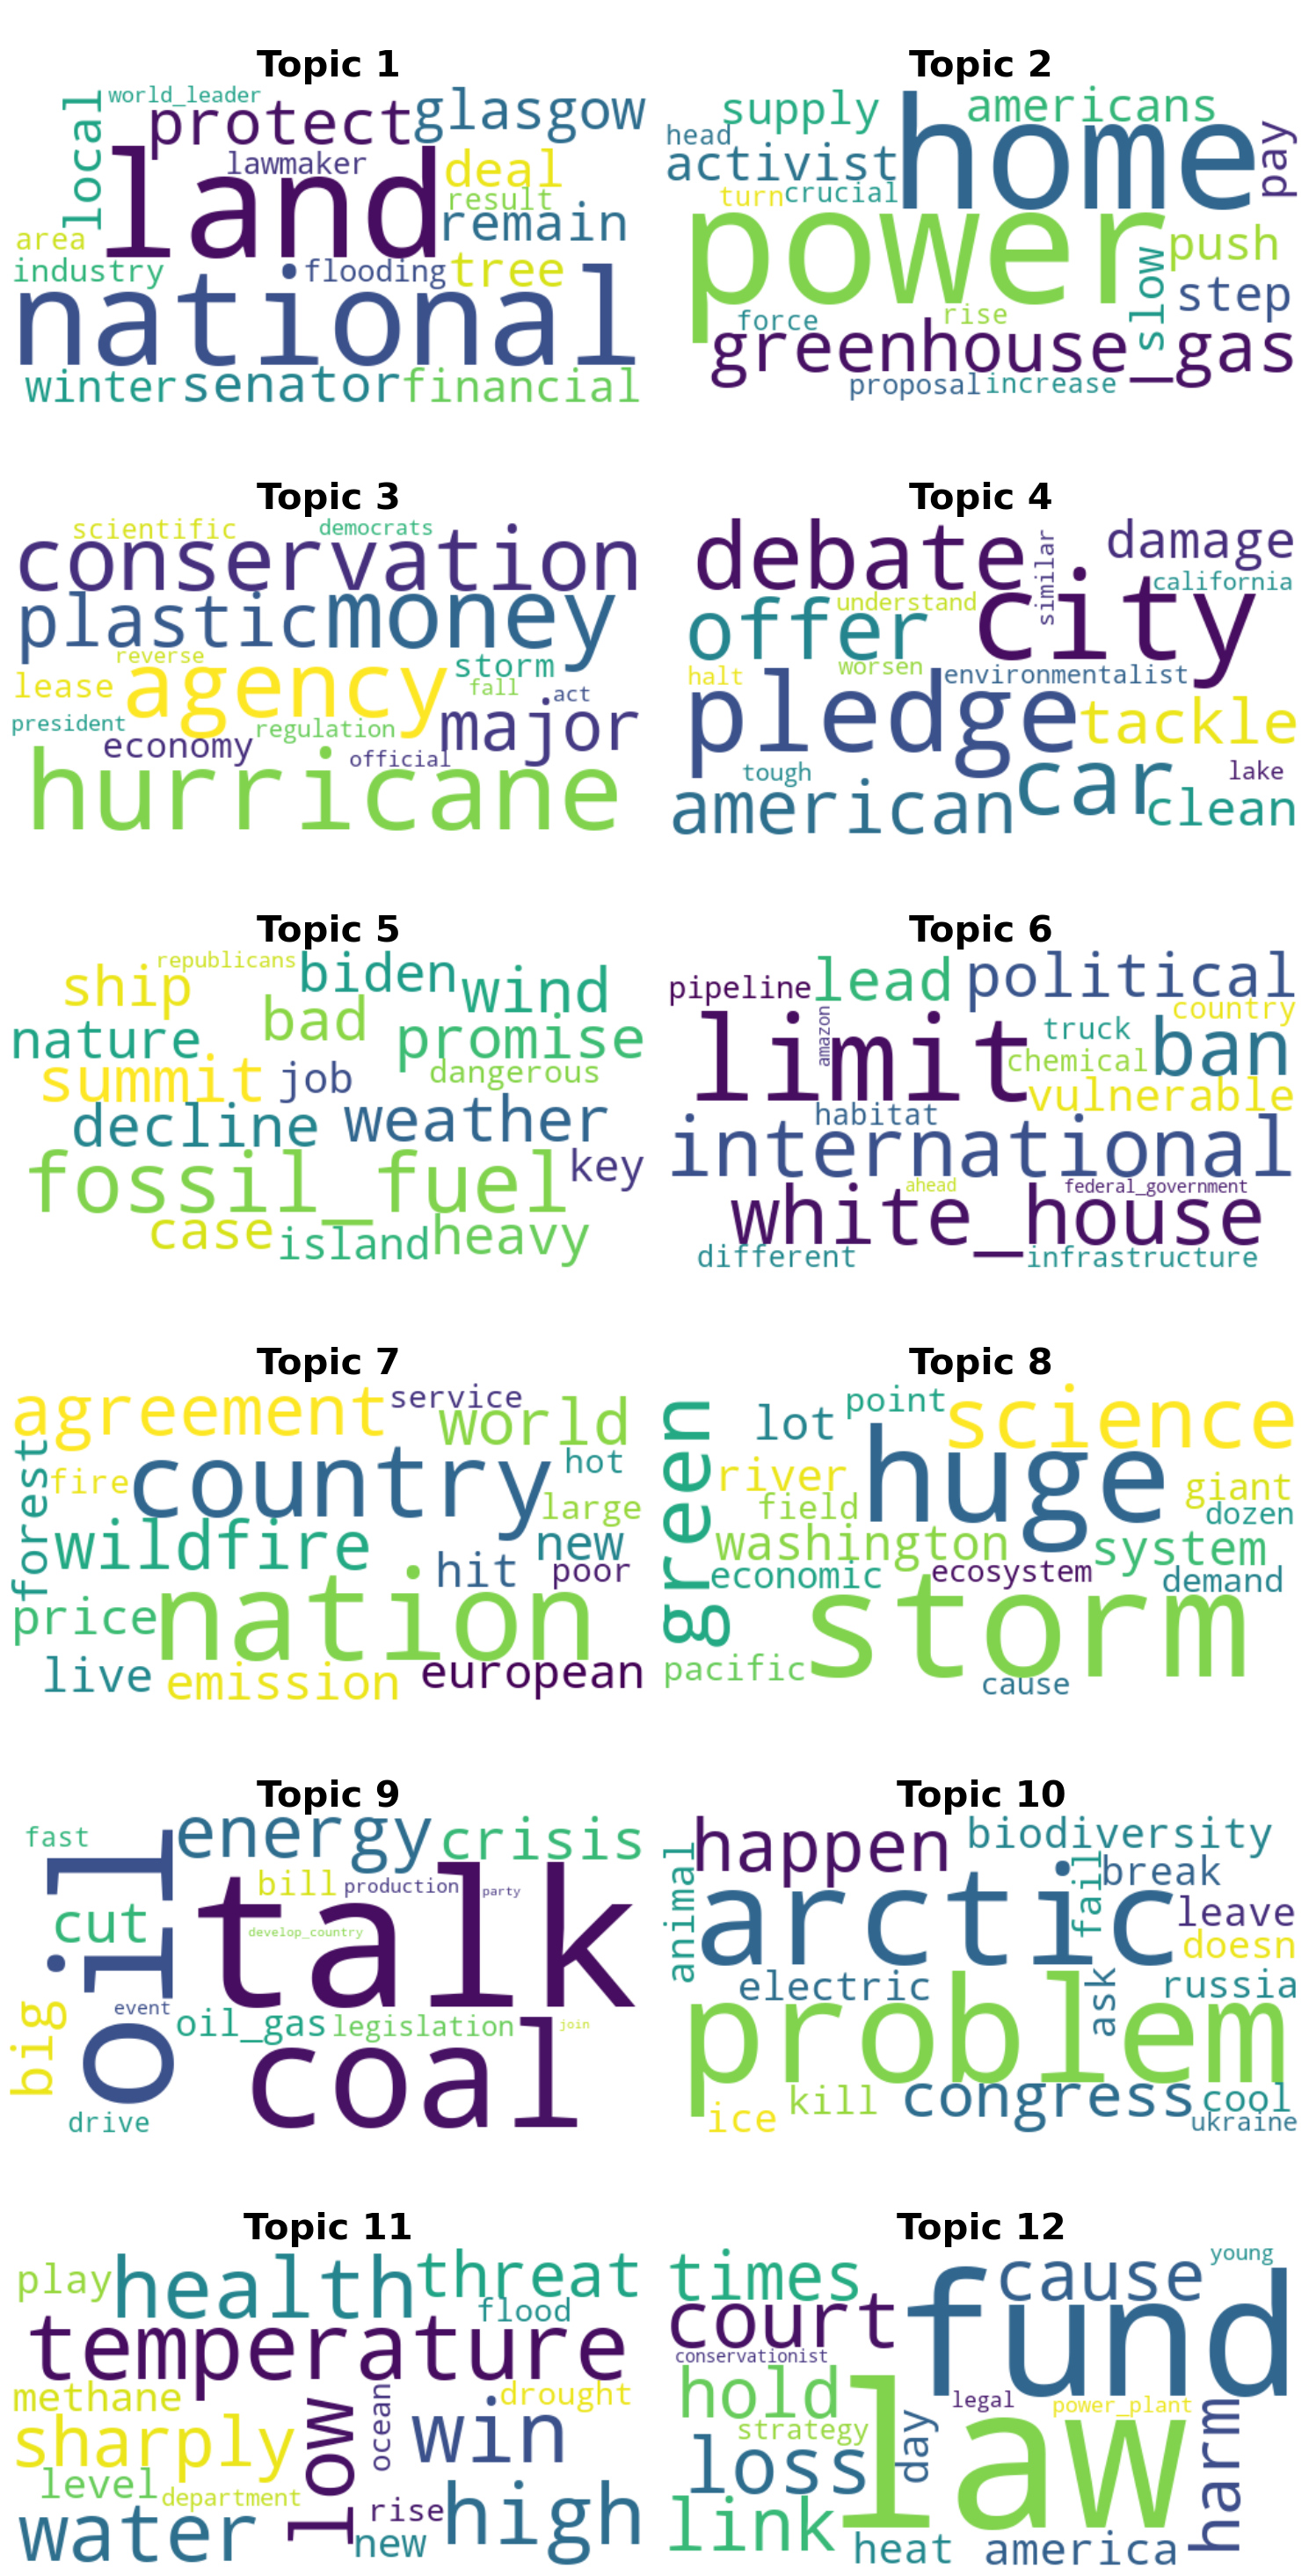

In [26]:
plot_wordclouds_for_all_topics(NYT_lda_tfidf, 17, "NYT")

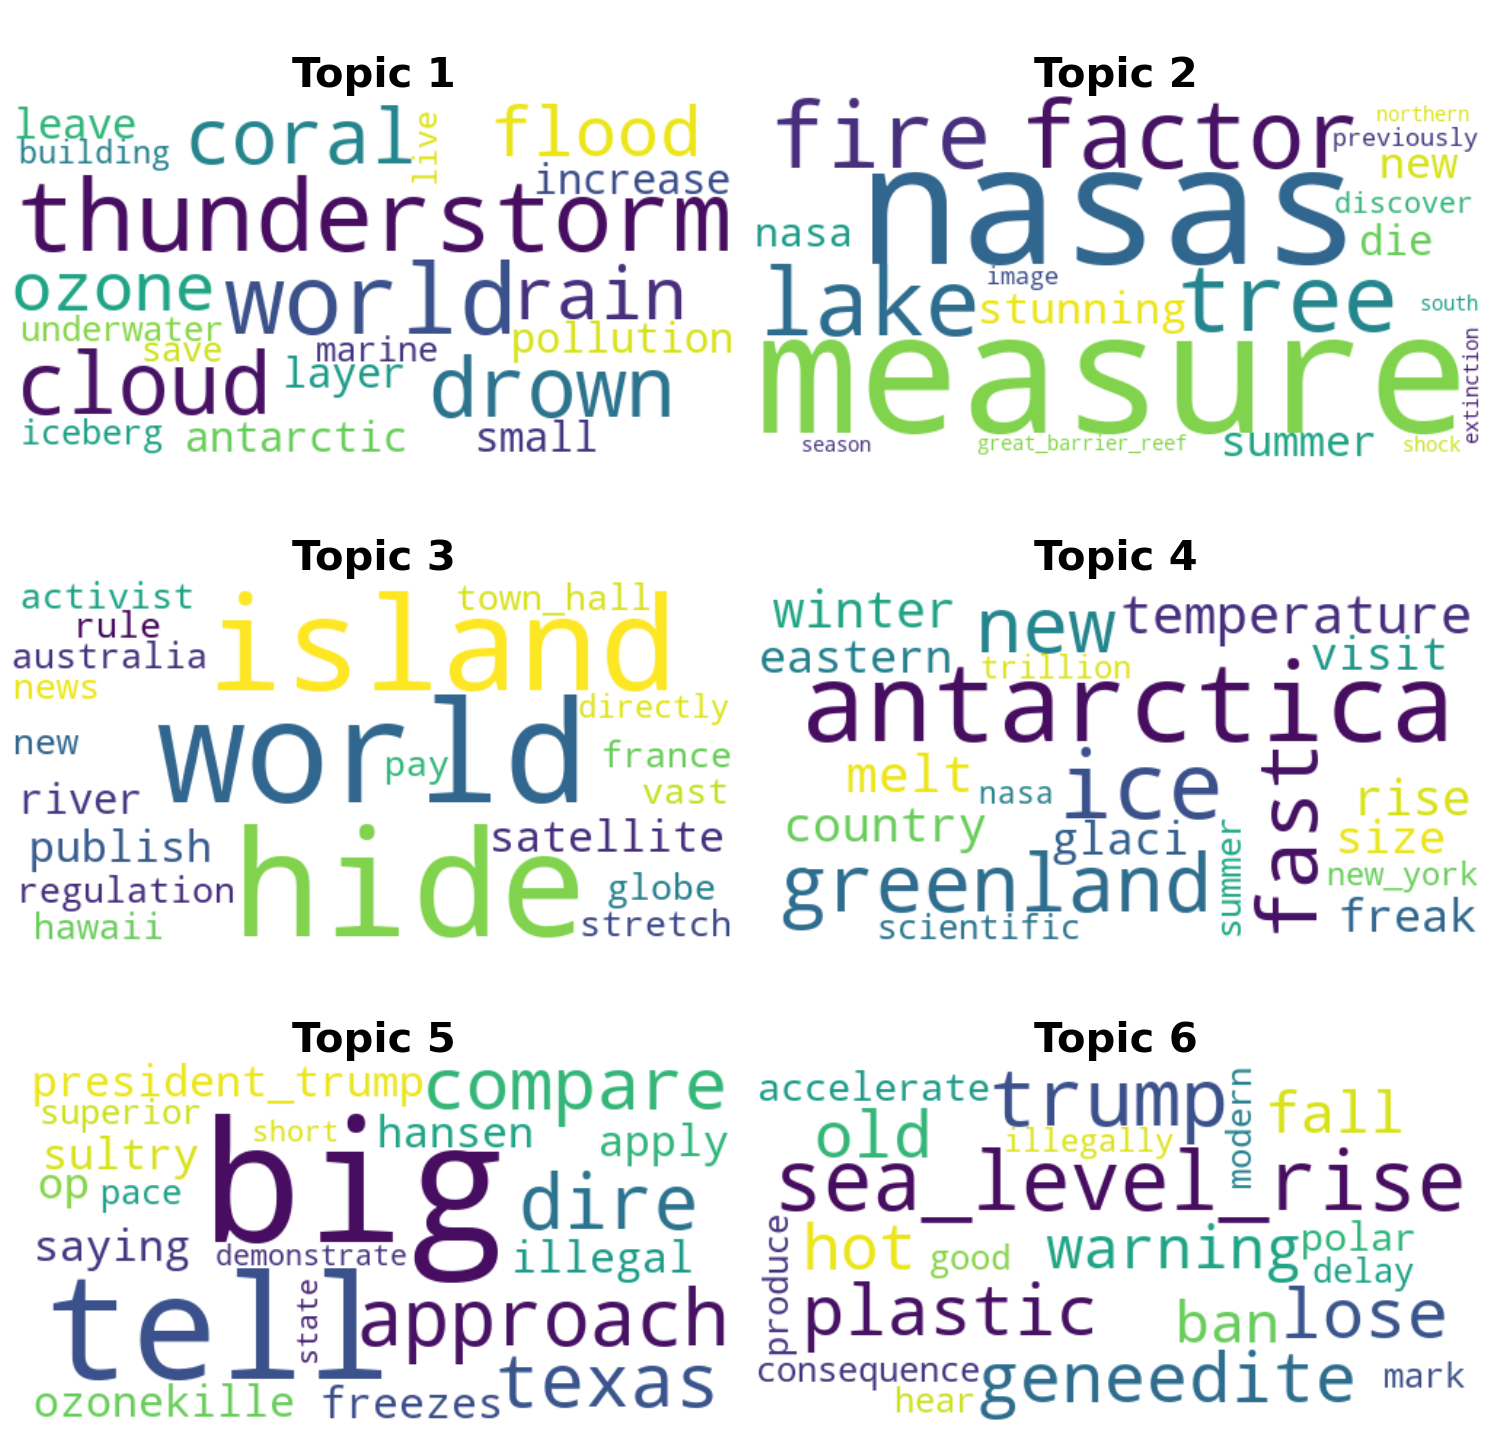

In [27]:
plot_wordclouds_for_all_topics(foxnews_lda_tfidf, 20, "Fox News")